In [1]:
%pylab inline
from pylab import *
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset
# This code is from GeoHotz github
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_train = fetch('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
Y_test = fetch('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz')[8:]

(60000, 28, 28)


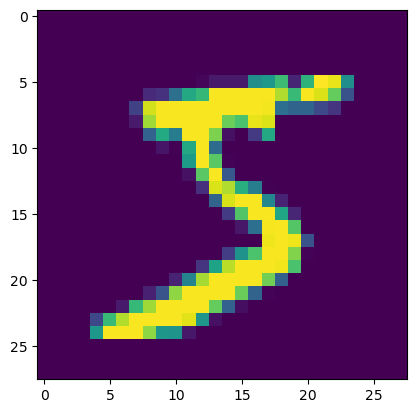

In [3]:
imshow(X_train[0])
print(X_train.shape)

In [4]:
import torch
import torch.nn as nn
from tqdm import trange, tqdm  # Import tqdm explicitly
import time

# first: flateen my data
# go through a 1st fully connected layer
# apply non linearity
# go through a 2nd fully connected layer
# apply something that gives me 10 probabilities


# Model
class ChiquitoModel(nn.Module):
    def __init__(self):
        super(ChiquitoModel, self).__init__()

        self.l1 = nn.Linear(784,128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128,10)
        #self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [6]:
import matplotlib.pyplot as plt

# Training

model = ChiquitoModel()

# set loss function
loss_function = nn.CrossEntropyLoss()

# set optimizer
optim = torch.optim.Adam(model.parameters())

losses, accuracies = [], []
BS = 32

# training loop
loop_tam = 1000
for i in (t := trange(loop_tam)):
    # select a batch of size BS
    samp = np.random.randint(0,X_train.shape[0], size = (BS))
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    # set all gradient contribution to zero
    optim.zero_grad()

    # perform forward pass
    out = model(X)

    # we want to the see the accuracy of the model as we progress with the iterations
    cat = torch.argmax(out,dim=1)
    accuracy = (cat == Y).float().mean()

    loss = loss_function(out, Y)

    # performa backward pass
    loss.backward()
    optim.step()

    # output some info
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description(f"Loss: {loss:.2f}, accuracy: {accuracy:.2f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.17, accuracy: 0.94: 100%|██████████| 1000/1000 [00:18<00:00, 54.84it/s]


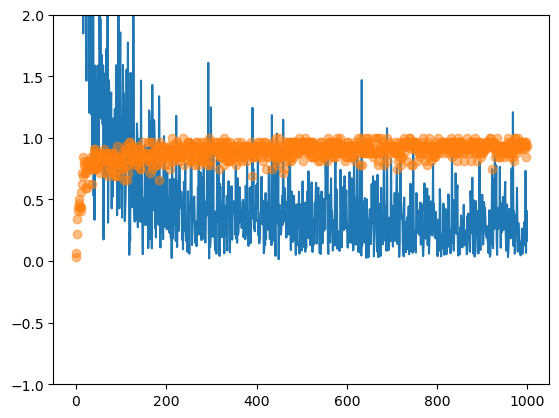

In [7]:
plt.ylim(-1,2)
plot(losses)
plot(accuracies, 'o', alpha = 0.5)

In [8]:
# Evaluation
Y_test_pred = torch.argmax(model(torch.tensor(X_test.reshape((-1,28*28))).float()), dim=1).numpy()
(Y_test == Y_test_pred).mean()

0.9257